# Building Complex Models Using the Functional API
One example of a nonsequential neural network is a Wide & Deep neural network.\
“Wide & Deep Learning for Recommender Systems,” Proceedings of the First Workshop
on Deep Learning for Recommender Systems (2016): 7–10.
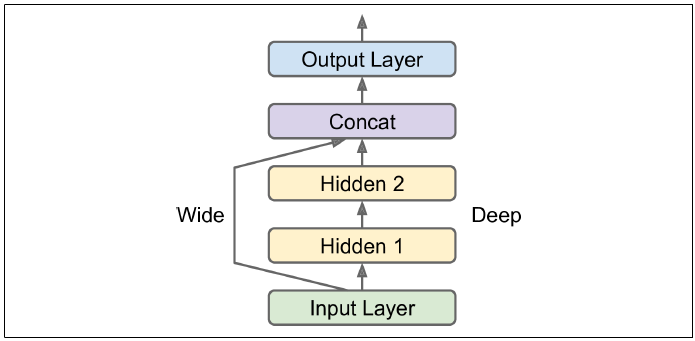

## 1- Let’s build such a neural network to tackle the California housing problem

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full)

In [6]:
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.fit_transform(x_valid)
x_test = scaler.fit_transform(x_test)

First, we need to create an Input object. This is a specification of the kind of input the model will get, including its shape and dtype. A model may actually have multiple inputs, as we will see shortly.

In [7]:
input_ = keras.layers.Input(shape=x_train.shape[1:])

Next, we create a Dense layer with 30 neurons, using the ReLU activation function.\
As soon as it is created, notice that we call it like a function, passing it the input. This is why this is called the Functional API. Note that we are just telling Keras how it should connect the layers together; no actual data is being processed
yet.

In [9]:
hidden1 =  keras.layers.Dense(30, activation="relu")(input_)

In [10]:
hidden2 = keras.layers.Dense(30, activation= "relu")(hidden1)

Next, we create a Concatenate layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer.\
You may prefer the keras.layers.concatenate() function, which creates a Concatenate layer and immediately calls it with the given inputs.

In [11]:
concat = keras.layers.Concatenate()([input_, hidden2])

Then we create the output layer, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation.

In [12]:
output = keras.layers.Dense(1)(concat)

Lastly, we create a Keras Model, specifying which inputs and outputs to use

In [14]:
model = keras.Model(inputs=[input_],outputs=[output])

In [23]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-4))

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [25]:
history = model.fit(x_train,y_train, epochs=30, validation_data=(x_valid,y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 3s 242us/sample - loss: 0.4578 - val_loss: 0.4218
Epoch 2/30
11610/11610 [==============================] - 1s 126us/sample - loss: 0.4567 - val_loss: 0.4217
Epoch 3/30
11610/11610 [==============================] - 2s 130us/sample - loss: 0.4562 - val_loss: 0.4217
Epoch 4/30
11610/11610 [==============================] - 2s 130us/sample - loss: 0.4558 - val_loss: 0.4215
Epoch 5/30
11610/11610 [==============================] - 2s 131us/sample - loss: 0.4555 - val_loss: 0.4214
Epoch 6/30
11610/11610 [==============================] - 1s 128us/sample - loss: 0.4553 - val_loss: 0.4211
Epoch 7/30
11610/11610 [==============================] - 2s 154us/sample - loss: 0.4550 - val_loss: 0.4209
Epoch 8/30
11610/11610 [==============================] - 2s 184us/sample - loss: 0.4548 - val_loss: 0.4209
Epoch 9/30
11610/11610 [==============================] - 1s 126us/sample - loss: 0.454

(0.0, 1.0)

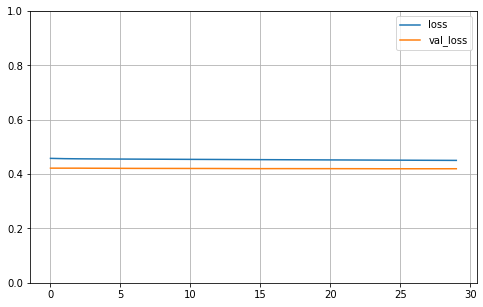

In [26]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) 

In [27]:
mse_test=model.evaluate(x_test, y_test)

5160/5160 [==============================] - 0s 73us/sample - loss: 0.4774


In [28]:
mse_test

0.47736493238182953

### But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path

For example, suppose we want to send five features through the wide path (features 0 to 4), and six features through the
deep path (features 2 to 7):
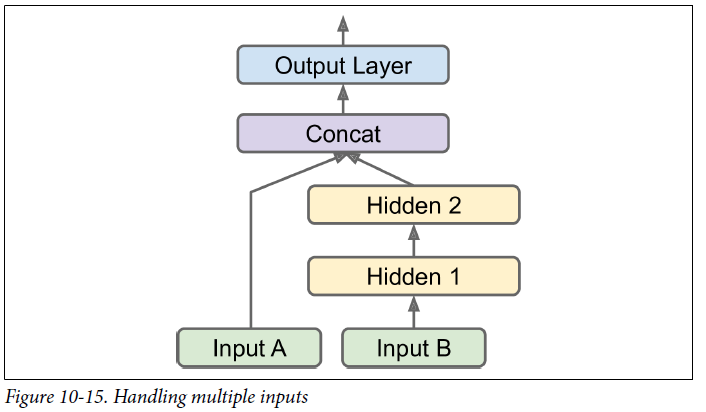

In [30]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.Model(inputs=[input_A,input_B], outputs=[output])

In [33]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))


In [34]:
x_train_A, x_train_B = x_train[:, :5], x_train[:, 2:]
x_valid_A, x_valid_B = x_valid[:, :5], x_valid[:, 2:]
x_test_A, x_test_B = x_test[:, :5], x_test[:, 2:]
x_new_A, x_new_B =  x_test_A[:3], x_test_B[:3]

In [35]:
history = model.fit((x_train_A, x_train_B), y_train, epochs=20, validation_data=((x_valid_A,x_valid_B),y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 218us/sample - loss: 2.7349 - val_loss: 1.0909
Epoch 2/20
11610/11610 [==============================] - 2s 139us/sample - loss: 0.9156 - val_loss: 0.6806
Epoch 3/20
11610/11610 [==============================] - 2s 143us/sample - loss: 0.6985 - val_loss: 0.5807
Epoch 4/20
11610/11610 [==============================] - 2s 145us/sample - loss: 0.6270 - val_loss: 0.5463
Epoch 5/20
11610/11610 [==============================] - 2s 141us/sample - loss: 0.5909 - val_loss: 0.5195
Epoch 6/20
11610/11610 [==============================] - 2s 147us/sample - loss: 0.5671 - val_loss: 0.5018
Epoch 7/20
11610/11610 [==============================] - 2s 168us/sample - loss: 0.5484 - val_loss: 0.4897
Epoch 8/20
11610/11610 [==============================] - 2s 151us/sample - loss: 0.5339 - val_loss: 0.4831
Epoch 9/20
11610/11610 [==============================] - 2s 142us/sample - loss: 0.521

In [36]:
mse= model.evaluate((x_test_A, x_test_B), y_test)

5160/5160 [==============================] - 0s 80us/sample - loss: 0.4616


In [37]:
mse

0.46158138786175457

In [38]:
ypred = model.predict((x_new_A,x_new_B))

In [39]:
ypred

array([[0.7144141],
       [2.5939922],
       [1.4765222]], dtype=float32)

In [40]:
y_test[:3]

array([0.695, 0.55 , 1.313])

# Using the Subclassing API to Build Dynamic Models

### Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method.

In [56]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) #handles standard args e.g. name
        self.hidden1= keras.layers.Dense(units, activation=activation)
        self.hidden2= keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        
        return main_output, aux_output
    
    
model = WideAndDeepModel()

In [57]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

So instead of passing y_train, we need to pass (y_train, y_train) (and the same goes for y_valid and y_test):

In [74]:
history = model.fit([x_train_A, x_train_B], [y_train, y_train], 
                    epochs=10, 
                    validation_data=([x_valid_A, x_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 165us/sample - loss: 0.3678 - output_1_loss: 0.3516 - output_2_loss: 0.5123 - val_loss: 8.7882 - val_output_1_loss: 9.0491 - val_output_2_loss: 6.4484
Epoch 2/10
11610/11610 [==============================] - 2s 163us/sample - loss: 0.3664 - output_1_loss: 0.3509 - output_2_loss: 0.5065 - val_loss: 10.1652 - val_output_1_loss: 10.4828 - val_output_2_loss: 7.3159
Epoch 3/10
11610/11610 [==============================] - 2s 164us/sample - loss: 0.3637 - output_1_loss: 0.3484 - output_2_loss: 0.5007 - val_loss: 10.5894 - val_output_1_loss: 10.9039 - val_output_2_loss: 7.7683
Epoch 4/10
11610/11610 [==============================] - 2s 171us/sample - loss: 0.3609 - output_1_loss: 0.3460 - output_2_loss: 0.4948 - val_loss: 10.2619 - val_output_1_loss: 10.5358 - val_output_2_loss: 7.8055
Epoch 5/10
11610/11610 [==============================] - 2s 202us/sample - loss: 0.3593 - output

In [59]:
total_loss, main_loss, aux_loss = model.evaluate([x_test_A, x_test_B], [y_test, y_test])

5160/5160 [==============================] - 1s 99us/sample - loss: 0.7487 - output_1_loss: 0.7488 - output_2_loss: 0.7397


In [67]:
print("Total loss:{} ,Main loss:{} ,AUX loss:{}  ".format(total_loss.round(2), main_loss.round(2), aux_loss))


Total loss:0.75 ,Main loss:0.75 ,AUX loss:0.7397376894950867  


In [69]:
y_pred_main, y_pred_aux = model.predict([x_new_A, x_new_B])

(0.0, 1.0)

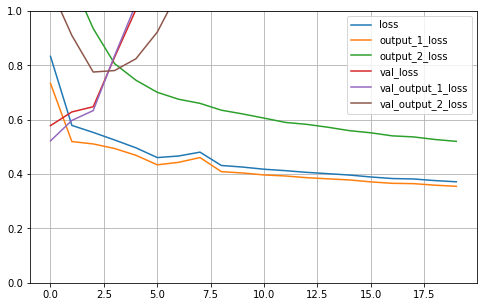

In [73]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) 

# Using TensorBoard for Visualization



To use it, you must modify your program so that it outputs the data you want to visualize to special binary log files called event files. Each binary data record is called a summary.\
Let’s start by defining the root log directory we will use for our TensorBoard logs, plus a small function that will generate a subdirectory path based on the current date and time so that it’s different at every run.

In [75]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [76]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [77]:
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [78]:
#The good news is that Keras provides a nice TensorBoard() callback:

In [79]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit([x_train_A, x_train_B], [y_train, y_train], 
                    epochs=20, 
                    validation_data=([x_valid_A, x_valid_B], [y_valid, y_valid]),
                    callbacks=[tensorboard_cb])


Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 258us/sample - loss: 0.3508 - output_1_loss: 0.3379 - output_2_loss: 0.4662 - val_loss: 15.1503 - val_output_1_loss: 15.4751 - val_output_2_loss: 12.2407
Epoch 2/20
11610/11610 [==============================] - 2s 169us/sample - loss: 0.3465 - output_1_loss: 0.3337 - output_2_loss: 0.4615 - val_loss: 15.8185 - val_output_1_loss: 16.1411 - val_output_2_loss: 12.9284
Epoch 3/20
11610/11610 [==============================] - 2s 155us/sample - loss: 0.3471 - output_1_loss: 0.3345 - output_2_loss: 0.4603 - val_loss: 15.7149 - val_output_1_loss: 16.0014 - val_output_2_loss: 13.1488
Epoch 4/20
11610/11610 [==============================] - 2s 148us/sample - loss: 0.3427 - output_1_loss: 0.3302 - output_2_loss: 0.4541 - val_loss: 16.6302 - val_output_1_loss: 16.9455 - val_output_2_loss: 13.8059
Epoch 5/20
11610/11610 [==============================] - 2s 148us/sample - loss: 0.3421 - 

Next, run the following command at the root of the project (or from anywhere else, as long as you point to the appropriate log directory):\
                $ tensorboard --logdir=./my_logs --port=6006\
                
                TensorBoard 2.0.0 at http://mycomputer.local:6006/ (Press CTRL+C to quit)

In [80]:
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit([x_train_A, x_train_B], [y_train, y_train], 
                    epochs=20, 
                    validation_data=([x_valid_A, x_valid_B], [y_valid, y_valid]),
                    callbacks=[tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 286us/sample - loss: 0.3312 - output_1_loss: 0.3217 - output_2_loss: 0.4167 - val_loss: 22.5015 - val_output_1_loss: 22.4810 - val_output_2_loss: 22.7013
Epoch 2/20
11610/11610 [==============================] - 2s 185us/sample - loss: 0.3284 - output_1_loss: 0.3188 - output_2_loss: 0.4145 - val_loss: 21.6109 - val_output_1_loss: 21.5321 - val_output_2_loss: 22.3366
Epoch 3/20
11610/11610 [==============================] - 2s 159us/sample - loss: 0.3272 - output_1_loss: 0.3179 - output_2_loss: 0.4109 - val_loss: 22.8313 - val_output_1_loss: 22.7733 - val_output_2_loss: 23.3688
Epoch 4/20
11610/11610 [==============================] - 2s 156us/sample - loss: 0.3278 - output_1_loss: 0.3185 - output_2_loss: 0.4117 - val_loss: 23.4336 - val_output_1_loss: 23.3683 - val_output_2_loss: 24.0377
Epoch 5/20
11610/11610 [==============================] - 2s 156us/sample - loss: 0.3266 - 